In [2]:
%load_ext autotime

import pygmo as pg
import numpy as np
import networkx as nx
import pandas as pd

import community as comm

import matplotlib.pyplot as plt

aarhus = ['aarhus_1.txt', 'aarhus_2.txt', 'aarhus_3.txt', 'aarhus_4.txt', 'aarhus_5.txt']

euair = ['euair_1.txt', 'euair_10.txt', 'euair_11.txt', 'euair_12.txt', 'euair_13.txt', 'euair_14.txt', 'euair_15.txt', 'euair_16.txt', 'euair_17.txt', 'euair_18.txt', 'euair_19.txt', 'euair_2.txt', 'euair_20.txt', 'euair_21.txt', 'euair_22.txt', 'euair_23.txt', 'euair_24.txt', 'euair_25.txt', 'euair_26.txt', 'euair_27.txt', 'euair_28.txt', 'euair_29.txt', 'euair_3.txt', 'euair_30.txt', 'euair_31.txt', 'euair_32.txt', 'euair_33.txt', 'euair_34.txt', 'euair_35.txt', 'euair_36.txt', 'euair_37.txt', 'euair_4.txt', 'euair_5.txt', 'euair_6.txt', 'euair_7.txt', 'euair_8.txt', 'euair_9.txt']

krackhardt = ['krackhardt_1.txt', 'krackhardt_2.txt', 'krackhardt_3.txt']

padgett = ['padgett_1.txt', 'padgett_2.txt']

_4layers = ['output_4layer_1.txt', 'output_4layer_2.txt', 'output_4layer_3.txt', 'output_4layer_4.txt']

_3layers = ['output_3layer_1.txt', 'output_3layer_2.txt', 'output_3layer_3.txt']


%%time

UsageError: Line magic function `%%time` not found.


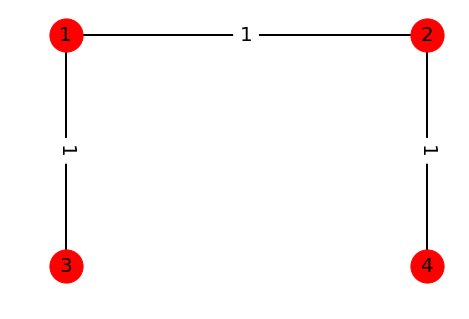

time: 461 ms


In [60]:
G=nx.Graph()
G.add_node(1,pos=(1,1))
G.add_node(2,pos=(2,1))
G.add_node(3,pos=(1,0))
G.add_node(4,pos=(2,0))
# G.add_edge(3,4,weight=1)
G.add_edge(1,3,weight=1)
G.add_edge(2,4,weight=1)
G.add_edge(1,2,weight=1)
pos=nx.get_node_attributes(G,'pos')
nx.draw(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, font_size=20)
nx.draw_networkx_edges(G, pos, width=2)
nx.draw_networkx_labels(G, pos, font_size = 20)
nx.draw_networkx_nodes(G, pos, node_size = 1100)
plt.savefig('beforeMerge1.png', dpi=300)

In [93]:
class community_function:
  def __init__(self, fileNames, alpha=None):
    self.fileNames = fileNames
    self.G = []
    self.alpha = alpha
    for fileName in self.fileNames:
      g = self.getNeighbourMatrixFromFile(fileName)
      self.G.append(g)
    self.dim = len(list(self.G[0].nodes))
    self.layers = len(fileNames)
      
  def fitness(self, x):
    d = {}
    for val, ind in zip(np.nditer(x), np.ndindex(x.shape[0])):
      d[ind[0]] = int(val)
      
    partitions = []
    for partitionNumber in set(d.values()):
      partition = []
      for key in d:
        if d[key] == partitionNumber:
          partition.append(key)
      partitions.append(partition)  
    
    fitness = 0
    for g in self.G:
      for partition in partitions:
        k_out = 0
        for node in partition:
          for i in g.neighbors(node):
            if i not in partition:
              k_out += 1

        k_in = 0
        for node in partition:
          for i in g.neighbors(node):
            if i in partition:
              k_in += 1
        k_in = k_in//2
        
        fitness += k_in/((k_in + k_out)**(self.alpha))
        
    return [0 - fitness]

  def get_bounds(self):
    return ([1] * self.dim, [self.dim] * self.dim)
  
  def get_nix(self):
    # Number of integer dimensions (all of them)
    print(self.dim)
    return self.dim
  
  def get_name(self):
    ret = "Best partition for multiplex graph\n"
    for fileName in self.fileNames:
      ret +="File: " + fileName + "\n"
    ret += "Dimension: " + str(self.dim)
    ret += "\n\n"
    return ret
  
  def getNeighbourMatrixFromFile(self, fileName):
    A = pd.read_csv(fileName, sep=" ", header=None)
    G = nx.from_numpy_matrix(np.array(A))
    return G
  
  def drawPartition(self, graphIndex=0, partition=None, fun=nx.spring_layout, suffix=None):
    if partition is None:
      raise ValueError("No partition passed as parameter!!")
    if type(partition) is list:
      partition = {key:val for key, val in enumerate(partition)}
    if type(partition) is not dict:
      raise ValueError("Invalid partititon as input: " + str(type(partition)))

    plt.clf()
      
    colors = self.getColors()
    G = self.G[graphIndex]
    pos = fun(G)
    count = 0
    
    for com in set(partition.values()):
      toDraw = True
      list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
      labels = dict()
      for node in list_nodes:
        labels[node] = node+1
      node_colors = np.zeros((len(list_nodes), 3))
      if len(list_nodes) <= 1:
        node_colors[:] = [1, 1, 1]
        if fun != nx.circular_layout:
          toDraw = False
      else:
        try:
          node_colors[:] = colors[count]
        except:
          node_colors[:] = [1, 1, 1]
        count += 1
      if toDraw:
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 200, node_color=node_colors)
        nx.draw_networkx_labels(G, pos, labels)
    nx.draw_networkx_edges(G, pos, width=0.4)
    
    outfile=self.fileNames[graphIndex] + str(suffix) + "_moea.png"
    plt.savefig(outfile, dpi=300)
    
  def getColors(self):
    return np.array([
            [166,206,227],
            [31,120,180],
            [178,223,138],
            [51,160,44],
            [251,154,153],
            [227,26,28],
            [253,191,111],
            [255,127,0],
            [202,178,214],
            [106,61,154],
            [255,255,153],
            [177,89,40]
          ])/255

time: 6.42 ms


40
40
40
40
40
40
40
40
40
40
40


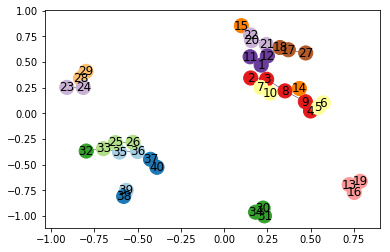

time: 2min 1s


In [94]:
for alpha in np.arange(0,1.1,0.1):
  # problem = pg.problem(community_function(aarhus))
  # problem = pg.problem(community_function(euair))
  # problem = pg.problem(community_function(krackhardt))
  # problem = pg.problem(community_function(padgett))
  problem = pg.problem(community_function(_4layers, alpha=0.75))
  # problem = pg.problem(community_function(_3layers))

  algo = pg.algorithm(pg.sga(gen=2000))
  population = pg.population(problem, 20)
  population = algo.evolve(population)
  champion_x = population.champion_x
  champion_x

  cf = problem.extract(object)
  for i in range(len(cf.G)):
    cf.drawPartition(i, list(champion_x), suffix='alpha_'+str(alpha))